In [79]:
import time
import mlx.core as mx
import mlx.nn as nn
import mlx.optimizers as optim
import numpy as np
from functools import partial
import matplotlib.pyplot as plt

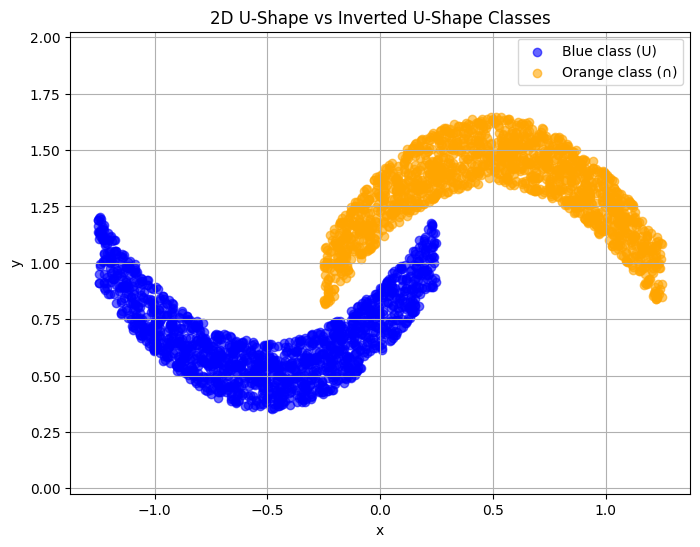

In [96]:
import numpy as np
import matplotlib.pyplot as plt

# Configuration
training_size = 1_500
wiggle = 0.15

# Helper function to add noise
def add_noise(shape, scale=wiggle):
    return np.random.uniform(-scale, scale, shape).astype(np.float32)

# Blue class: U shape centered at a 2D point
blue_center = np.array([-0.5, 0.5])
blue_width = 1.5

x_blue = np.random.uniform(blue_center[0] - blue_width / 2,
                           blue_center[0] + blue_width / 2,
                           (training_size, 1)).astype(np.float32)

def blue_curve(x, center):
    return (x - center[0])**2 + center[1] + add_noise(x.shape)  # U shape centered at blue_center

y_blue = blue_curve(x_blue, blue_center)

# Orange class: ∩ shape centered at a 2D point
orange_center = np.array([0.5, 1.5])
orange_width = 1.5

x_orange = np.random.uniform(orange_center[0] - orange_width / 2,
                             orange_center[0] + orange_width / 2,
                             (training_size, 1)).astype(np.float32)

def orange_curve(x, center):
    return -(x - center[0])**2 + center[1] + add_noise(x.shape)  # Inverted U centered at orange_center

y_orange = orange_curve(x_orange, orange_center)

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(x_blue, y_blue, color='blue', alpha=0.6, label='Blue class (U)')
plt.scatter(x_orange, y_orange, color='orange', alpha=0.6, label='Orange class (∩)')
plt.title("2D U-Shape vs Inverted U-Shape Classes")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()


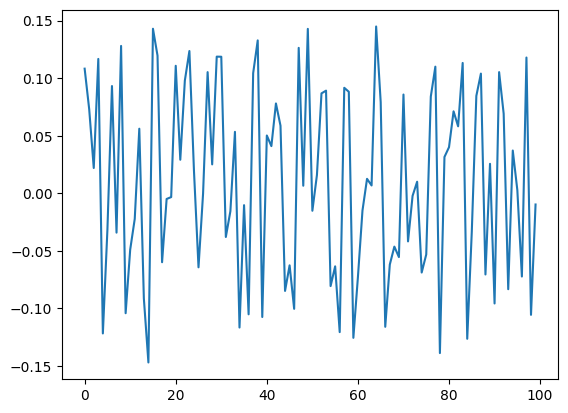

In [98]:
plt.plot(add_noise(100))

In [81]:
# training_size = 3_000
# wiggle = 0.01

# x_blue = np.random.uniform(-.25-1/3, -.25+1/3, (training_size, 1)).astype(np.float32)

# def blue(x):
#     return 0.1 + np.sqrt(1 - (x + .25)** 2) + np.random.uniform(-wiggle, wiggle, (training_size, 1)).astype(np.float32)
# def orange(x):
#     return 2 - np.sqrt(1 - x ** 2) + np.random.uniform(-wiggle, wiggle, (training_size, 1)).astype(np.float32)

# y_blue = blue(x_blue)
# plt.scatter(x_blue, y_blue, label='blue');

# x_orange = np.random.uniform(-1/3, 1/3, (training_size, 1)).astype(np.float32)
# y_orange = orange(x_orange)

# plt.scatter(x_orange, y_orange, label='orange');
# plt.legend();

In [82]:
x_blue.shape, x_orange.shape, type(x_orange)

((1500, 1), (1500, 1), numpy.ndarray)

In [83]:
xs = mx.concat([mx.array(x_blue), mx.array(x_orange)])
ys = mx.concat([mx.array(y_blue), mx.array(y_orange)])

Xs = mx.concat([xs, ys], axis=1)
target = mx.concat([mx.ones(len(x_orange)), mx.zeros(len(x_orange))])

Xs.shape, target.shape

((3000, 2), (3000,))

In [84]:
mean = Xs.mean(axis=0)       # shape (2,)
std = Xs.std(axis=0)         # shape (2,)
X_norm = (Xs - mean) / std

In [85]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(np.array(X_norm), list(target))
# X_train, X_test, y_train, y_test = train_test_split(np.array(Xs), list(target))
y_train = mx.array(y_train)
y_test = mx.array(y_test)

In [86]:
X_train[:10], y_train[:10]

(array([[-1.8804842 , -0.14781356],
        [-0.8829437 , -1.2253898 ],
        [ 0.69303614,  1.6584648 ],
        [ 0.21597554,  1.2824608 ],
        [ 0.23623472, -0.14144732],
        [-0.18908176, -0.58092874],
        [-0.05966829,  0.47870094],
        [ 0.30262378,  0.7863189 ],
        [-1.4230083 , -0.9727107 ],
        [-1.3346275 , -1.0872107 ]], dtype=float32),
 array([1, 1, 0, ..., 0, 1, 1], dtype=float32))

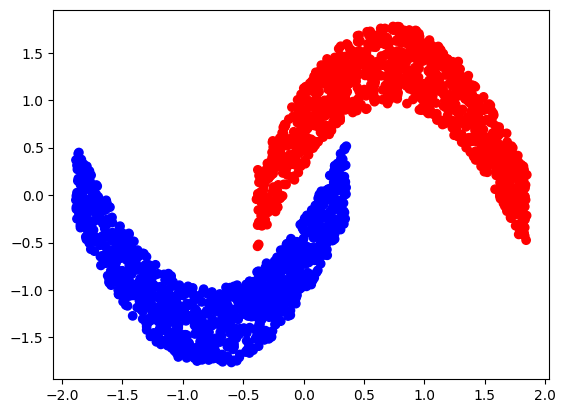

In [87]:
colors = ['red' if y.item() == 0 else 'blue' for y in y_train]
plt.scatter(X_train[:,0], X_train[:,1], color=colors);

In [88]:
X_train.shape, X_test.shape

((2250, 2), (750, 2))

In [94]:
hidden_size_1 = 20
hidden_size_2 = 10
learning_rate = 5
batch_size = 1_000
epochs = 30

# 1. Define the model
class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, hidden_size_1),
            nn.Tanh(),
            nn.Linear(hidden_size_1, hidden_size_2),
            nn.Tanh(),
            nn.Linear(hidden_size_2, 1),
        )

    def __call__(self, x):
        return self.net(x)

# 2. Generate training data
np.random.seed(42)

# 3. Initialize model and optimizer
model = MyModel()

def loss_fn(model, X, y):
    return nn.losses.binary_cross_entropy(model(X).reshape(-1), y, reduction="mean")

optimizer = optim.SGD(learning_rate=learning_rate)
loss_and_grad_fn = nn.value_and_grad(model, loss_fn)

@partial(mx.compile, inputs=model.state, outputs=model.state)
def step(X, y):
    print(X.shape, y.shape)
    loss, grads = loss_and_grad_fn(model, X, y)
    optimizer.update(model, grads)
    return loss

@partial(mx.compile, inputs=model.state)
def eval_fn(X, y):
    probs = mx.sigmoid(model(X))
    preds = (probs > 0.5).astype(mx.float32)
    return mx.mean(preds.reshape(-1) == y)

def batch_iterate(batch_size, X, y):
    perm = mx.array(np.random.permutation(y.size))
    for s in range(0, y.size, batch_size):
        ids = perm[s : s + batch_size]
        # print(y[ids].mean().item())
        yield X[ids], y[ids]

i = 0

# 4. Training loop
tic = time.perf_counter()

for e in range(epochs):
    for X, y in batch_iterate(batch_size, X_train, y_train):
        step(mx.array(X), y)
        mx.eval(model.state)
    accuracy = eval_fn(mx.array(X_test), y_test)
    loss = loss_fn(model, mx.array(X_test), y_test)
    toc = time.perf_counter()
    print(
        f"Epoch {e}: Test accuracy {accuracy.item():.3f}, Loss: {loss:.3f},"
        f" Time {toc - tic:.3f} (s)"
    )

(1000, 2) (1000,)
(250, 2) (250,)
Epoch 0: Test accuracy 0.928, Loss: 0.231, Time 0.017 (s)
Epoch 1: Test accuracy 0.940, Loss: 0.151, Time 0.021 (s)
Epoch 2: Test accuracy 0.933, Loss: 0.186, Time 0.029 (s)
Epoch 3: Test accuracy 0.941, Loss: 0.137, Time 0.033 (s)
Epoch 4: Test accuracy 0.944, Loss: 0.137, Time 0.037 (s)
Epoch 5: Test accuracy 0.933, Loss: 0.188, Time 0.041 (s)
Epoch 6: Test accuracy 0.943, Loss: 0.142, Time 0.044 (s)
Epoch 7: Test accuracy 0.943, Loss: 0.132, Time 0.048 (s)
Epoch 8: Test accuracy 0.943, Loss: 0.135, Time 0.052 (s)
Epoch 9: Test accuracy 0.945, Loss: 0.119, Time 0.056 (s)
Epoch 10: Test accuracy 0.944, Loss: 0.118, Time 0.059 (s)
Epoch 11: Test accuracy 0.944, Loss: 0.134, Time 0.062 (s)
Epoch 12: Test accuracy 0.951, Loss: 0.109, Time 0.066 (s)
Epoch 13: Test accuracy 0.953, Loss: 0.107, Time 0.070 (s)
Epoch 14: Test accuracy 0.951, Loss: 0.113, Time 0.074 (s)
Epoch 15: Test accuracy 0.949, Loss: 0.114, Time 0.078 (s)
Epoch 16: Test accuracy 0.956, L

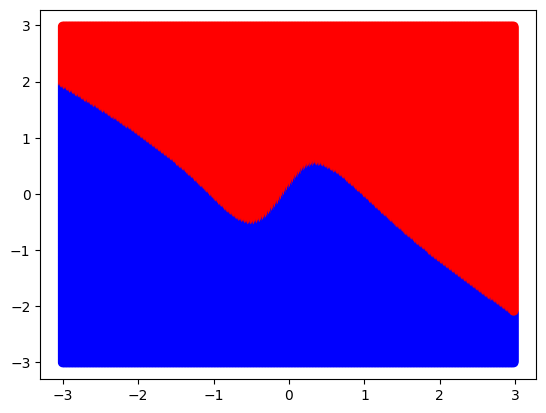

In [95]:
a = mx.arange(-3,3,0.02)
b = mx.arange(-3,3,0.02)
a.shape, b.shape

aa, bb = np.meshgrid(a, b, indexing='ij')

# Stack and reshape to Cartesian product
cartesian = np.stack([aa.ravel(), bb.ravel()], axis=1)

len(cartesian)

colors = ['red' if y.item() == 0 else 'blue' for y in (np.array(mx.sigmoid(model(mx.array(cartesian))) > 0.5)).astype(int)]
plt.scatter(cartesian[:,0], cartesian[:,1], color=colors);

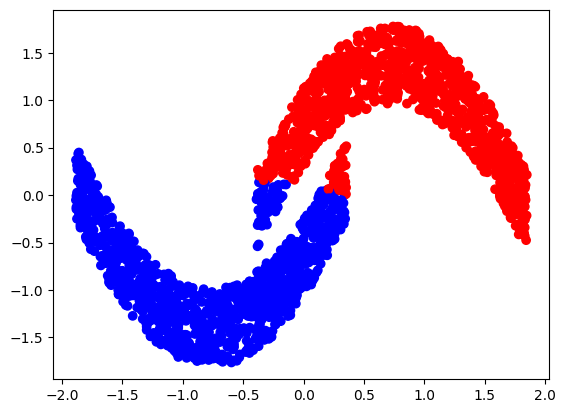

In [91]:
colors = ['red' if y.item() == 0 else 'blue' for y in (np.array(mx.sigmoid(model(mx.array(X_train))) > 0.5)).astype(int)]
plt.scatter(X_train[:,0], X_train[:,1], color=colors);

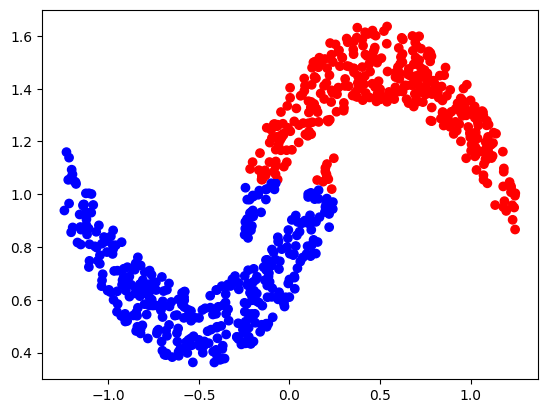

In [92]:
X_T = (X_test * std) + mean
colors = ['red' if y.item() == 0 else 'blue' for y in (np.array(mx.sigmoid(model(mx.array(X_test))) > 0.5)).astype(int)]
plt.scatter(X_T[:,0], X_T[:,1], color=colors);

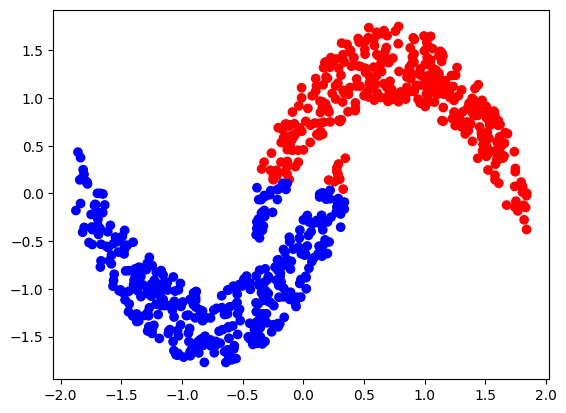

In [93]:
colors = ['red' if y.item() == 0 else 'blue' for y in (np.array(mx.sigmoid(model(mx.array(X_test))) > 0.5)).astype(int)]
plt.scatter(X_test[:,0], X_test[:,1], color=colors);